# Paper Reproduction

## Goal of the project
Reproduce the results from the paper "Predicting the direction of stock market prices using random forest."

## Import Libraries

In [76]:
import import_ipynb
import technical_indicators as ta

In [77]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,4.5) # Make the default figures a bit bigger

import numpy as np
import random
import math
#Make this notebook reproducible 
np.random.seed(42)
random.seed(42)


import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import f1_score, precision_score, confusion_matrix, recall_score, accuracy_score
from sklearn.model_selection import train_test_split

## Data


In [78]:
aapl = pd.read_csv('AAPL(RF).csv')
aapl.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-03-31,33.641430,33.801430,33.494286,33.571430,22.726398,107664900
1,2010-04-01,33.915714,34.104286,33.250000,33.709999,22.820208,150786300
2,2010-04-05,33.568573,34.072857,33.538570,34.070000,23.063911,171126900
3,2010-04-06,34.028572,34.320000,33.857143,34.220001,23.165457,111754300
4,2010-04-07,34.221428,34.560001,34.094284,34.371429,23.267965,157125500


## Exponential smoothing

In [79]:
def get_exp_preprocessing(df, alpha=0.9):
    edata = df.ewm(alpha=alpha).mean()    
    return edata

In [80]:
saapl = get_exp_preprocessing(aapl)
saapl.head() #saapl stands for smoothed aapl

C:\Users\30683\AppData\Local\Temp\ipykernel_8604\2838536098.py:2: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['Date'], dtype='object')
  edata = df.ewm(alpha=alpha).mean()


,Open,High,Low,Close,Adj Close,Volume
0,33.641430,33.801430,33.494286,33.571430,22.726398,1.076649e+08
1,33.890779,34.076754,33.272208,33.697402,22.811680,1.468662e+08
2,33.600503,34.073243,33.512174,34.033076,23.038915,1.687227e+08
3,33.985804,34.295347,33.822677,34.201325,23.152814,1.174460e+08
4,34.197868,34.533538,34.067126,34.354420,23.256451,1.531579e+08


## Feature Extraction - Technical Indicators

In [81]:
def feature_extraction(data):
    for x in [5, 14, 26, 44, 66]:
        data = ta.relative_strength_index(data, n=x)
        data = ta.stochastic_oscillator_d(data, n=x)
        data = ta.accumulation_distribution(data, n=x)
        data = ta.average_true_range(data, n=x)
        data = ta.momentum(data, n=x)
        data = ta.money_flow_index(data, n=x)
        data = ta.rate_of_change(data, n=x)
        data = ta.on_balance_volume(data, n=x)
        data = ta.commodity_channel_index(data, n=x)
        data = ta.ease_of_movement(data, n=x)
        data = ta.trix(data, n=x)
        data = ta.vortex_indicator(data, n=x)
    
    data['ema50'] = data['Close'] / data['Close'].ewm(50).mean()
    data['ema21'] = data['Close'] / data['Close'].ewm(21).mean()
    data['ema14'] = data['Close'] / data['Close'].ewm(14).mean()
    data['ema5'] = data['Close'] / data['Close'].ewm(5).mean()
        
    #Williams %R is missing
    data = ta.macd(data, n_fast=12, n_slow=26)
    
    del(data['Open'])
    del(data['High'])
    del(data['Low'])
    del(data['Volume'])
    
    return data
   
def compute_prediction_int(df, n):
    pred = (df.shift(-n)['Close'] >= df['Close'])
    pred = pred.iloc[:-n]
    return pred.astype(int)

def prepare_data(df, horizon):
    data = feature_extraction(df).dropna().iloc[:-horizon]
    data['pred'] = compute_prediction_int(data, n=horizon)
    del(data['Close'])
    return data.dropna()

###### Prepare the data with a prediction horizon of 60 days

In [82]:
data = prepare_data(saapl, 60)

y = data['pred']

#remove the output from the input
features = [x for x in data.columns if x not in ['gain', 'pred']]
X = data[features]

In [83]:
train_size = 2*len(X) // 3

X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]
print('len X_train', len(X_train))
print('len y_train', len(y_train))
print('len X_test', len(X_test))
print('len y_test', len(y_test))

len X_train 578
len y_train 578
len X_test 289
len y_test 289


## Random Forests (Regressor)

In [84]:
rf = RandomForestRegressor(n_jobs=-1, max_features = 'sqrt', n_estimators=65, random_state=42)
rf.fit(X_train, y_train.values.ravel());

In [85]:
predictions = rf.predict(X_test)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

0.21873835507053474

## Random Forests (Classifier)

In [86]:
data2 = prepare_data(saapl, 10)

y2 = data2['pred']
X2 = data2[features]
train_size2 = 2*len(X2) // 3
features = [x for x in data.columns if x not in ['gain', 'pred']]
X2 = data2[features]
X2_train = X2[:train_size2]
X2_test = X2[train_size2:]
y2_train = y2[:train_size2]
y2_test = y2[train_size2:]
rf2 = RandomForestClassifier(n_jobs=-1, n_estimators=65, random_state=42)
rf2.fit(X2_train, y2_train.values.ravel());
pred = rf2.predict(X2_test)
precision = precision_score(y_pred=pred, y_true=y2_test)
recall = recall_score(y_pred=pred, y_true=y2_test)
f1 = f1_score(y_pred=pred, y_true=y2_test)
accuracy = accuracy_score(y_pred=pred, y_true=y2_test)
confusion = confusion_matrix(y_pred=pred, y_true=y2_test)

print('precision: {0:1.2f}, recall: {1:1.2f}, f1: {2:1.2f}, accuracy: {3:1.2f}'.format(precision, recall, f1, accuracy))
print('Confusion Matrix')
print(confusion)

precision: 0.63, recall: 0.78, f1: 0.70, accuracy: 0.58
Confusion Matrix
[[ 26  92]
 [ 45 160]]



## LSTM

## Load packages

In [87]:
#Load packges
import pandas as pd
import yfinance as yf
stock_data = yf.download('AAPL', start='2010-03-31', end='2014-12-09')

import math
import numpy as np
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import matplotlib
from matplotlib import pyplot

[*********************100%***********************]  1 of 1 completed


## Plot stock price history

Text(0, 0.5, 'Prices')

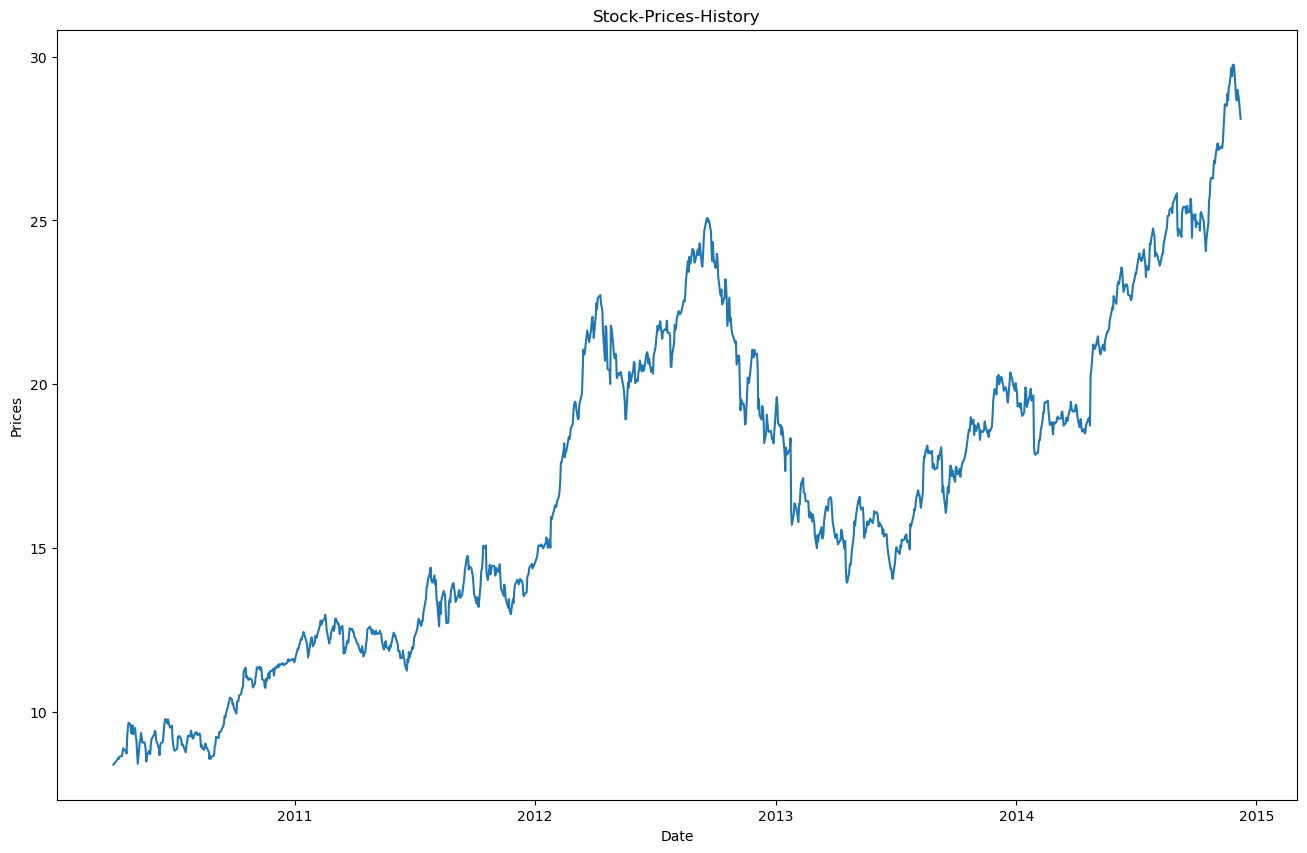

In [88]:
#Plot stock price history
plt.figure(figsize=(16, 10))
plt.title('Stock-Prices-History')
plt.plot(stock_data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices')


## Set window szie as 60days and split the data

In [89]:
close_prices = aapl['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.667)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

#set up window size as 60
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [12]:
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

## Build LSTM model

In [13]:
lstm = keras.Sequential()
lstm.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
lstm.add(layers.LSTM(100, return_sequences=False))
lstm.add(layers.Dense(25))
lstm.add(layers.Dense(1))
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [14]:
#Epoch equals 50
lstm.compile(optimizer='adam', loss='mean_squared_error')
lstm.fit(x_train, y_train, batch_size= 1, epochs=50)

Epoch 1/50
730/730 [==============================] - 15s 17ms/step - loss: 0.0019
Epoch 2/50
730/730 [==============================] - 12s 17ms/step - loss: 0.0014
Epoch 3/50
730/730 [==============================] - 12s 17ms/step - loss: 5.9231e-04
Epoch 4/50
730/730 [==============================] - 12s 17ms/step - loss: 6.5838e-04
Epoch 5/50
730/730 [==============================] - 12s 17ms/step - loss: 5.1696e-04
Epoch 6/50
730/730 [==============================] - 12s 17ms/step - loss: 5.0984e-04
Epoch 7/50
730/730 [==============================] - 12s 17ms/step - loss: 4.5932e-04
Epoch 8/50
730/730 [==============================] - 12s 17ms/step - loss: 4.1189e-04
Epoch 9/50
730/730 [==============================] - 13s 17ms/step - loss: 5.2420e-04
Epoch 10/50
730/730 [==============================] - 13s 17ms/step - loss: 5.8028e-04
Epoch 11/50
730/730 [==============================] - 13s 17ms/step - loss: 4.2180e-04
Epoch 12/50
730/730 [============================

## LSTM RMSE

In [15]:
#RMSE value
predictions = lstm.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

13/13 [==============================] - 1s 11ms/step


0.7521111934221161

C:\Users\30683\AppData\Local\Temp\ipykernel_5720\3865371060.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


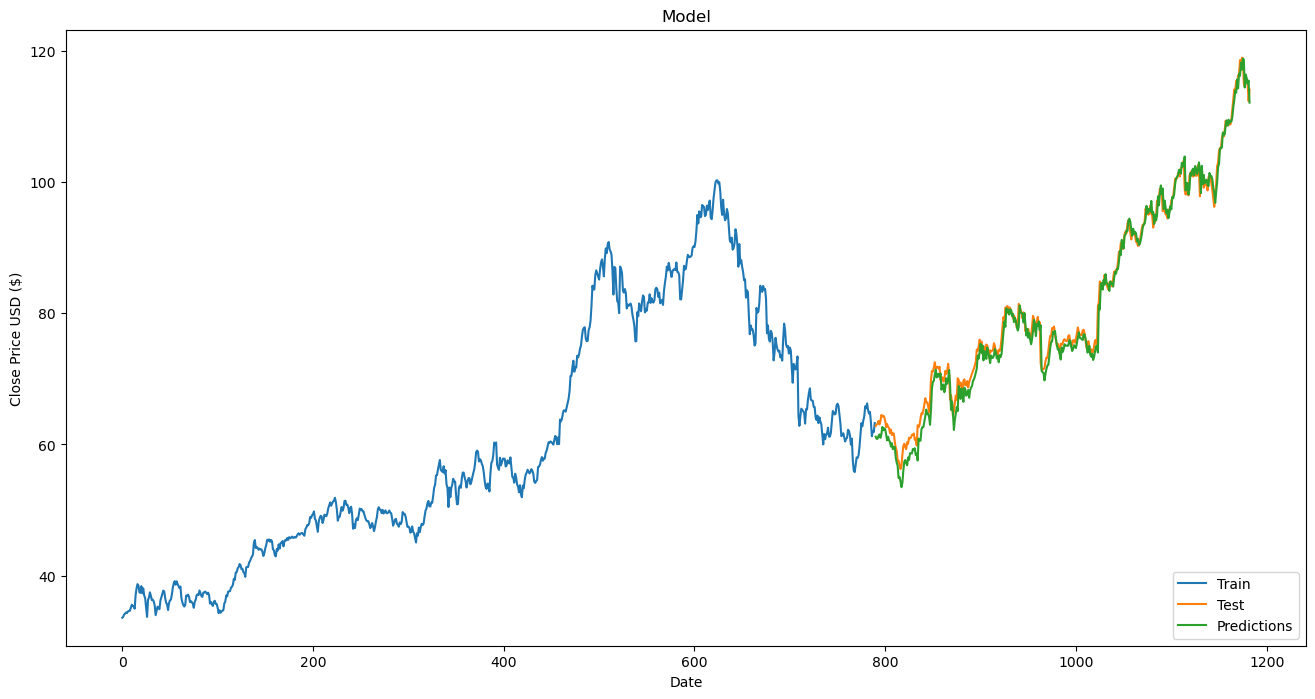

In [16]:
data = aapl.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
plt.show()